<a href="https://colab.research.google.com/github/werd0n4/hand-gesture-classification/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

---


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!ls

drive  sample_data


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import os
import cv2
import glob
import random
from matplotlib import pyplot as plt

# Constant parameters

---



In [5]:
horiz_x = 174
vert_y = 131
imgs_train_path = '/content/drive/My Drive/Colab Notebooks/Rozszerzony_dataset/Train/'
imgs_test_path = '/content/drive/My Drive/Colab Notebooks/Rozszerzony_dataset/Test/'

In [6]:

class_names = {
    0: "Undefined",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "A",
    7: "B",
    8: "C",
    9: "D",
    10: "E",
    11: "F",
    12: "G",
    13: "H",
    14: "I",
    15: "K",
    16: "L",
    17: "M",
    18: "N",
    19: "O",
    20: "P",
    21: "R",
    22: "S",
    23: "T",
    24: "U",
    25: "W",
    26: "Y",
    27: "Z"
}


# Auxiliary functions

---


In [7]:

def resize(path):
    img_counter = 0

    for dirname in os.listdir(path): 
        for filename in os.listdir(os.path.join(path, dirname)):
            image_path = os.path.join(path, dirname, filename)
            img = cv2.imread(image_path)
            resized_img = cv2.resize(img, (horiz_x, vert_y))
            cv2.imwrite(image_path, resized_img)
            img_counter += 1
    
    print('Images in set: ' + str(img_counter))


In [8]:

def sanity_check(path):
    counter = 0

    for dirname in os.listdir(path): 
        for filename in os.listdir(os.path.join(path, dirname)):
            image_path = os.path.join(path, dirname, filename)
            img = cv2.imread(image_path)
            if img.shape != (horiz_x, vert_y, 3):
                counter += 1

    print('Sanity result: ' + str(counter))

In [9]:

def show_img(index, X, Y):
    # plt.imshow(X[index])
    plt.imshow(cv2.cvtColor(X[index],cv2.COLOR_BGR2RGB).astype('float32'))
    plt.show()
    nmb = int(np.where(Y[index] == 1)[0])
    print("On image: " + class_names[nmb])

## Load dataset

In [10]:

def load_dataset():
    trainlist = glob.glob(f'{imgs_train_path}/*/*')
    testlist = glob.glob(f'{imgs_test_path}/*/*')
    X_train = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in trainlist] )
    X_test = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in testlist] )

    # Y_train = np.array([np.zeros(28) for fname in trainlist])
    Y_train = np.array([0 for fname in trainlist])
    for i,fname in enumerate(trainlist):
        img_id = fname.split('/')[7]
        img_id = img_id.split('_')[0]
        # Y_train[i][img_id] = 1
        Y_train[i] = img_id


    # Y_test = np.array([np.zeros(28) for fname in testlist])
    Y_test = np.array([0 for fname in testlist])
    for i,fname in enumerate(testlist):
        img_id = fname.split('/')[7]
        img_id = img_id.split('_')[0]
        # Y_test[i][img_id] = 1
        Y_test[i] = img_id

    return X_train, Y_train, X_test, Y_test


## Create network model

In [24]:

def create_model():
    model = Sequential()
    
    # CONVOLUTIONAL LAYER
    model.add(Conv2D(
        filters=6, 
        kernel_size=(3,3), 
        input_shape=(131, 174, 3), 
        activation='relu'
    ))

    # POOLING LAYER
    model.add(MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    ))

    # CONVOLUTIONAL LAYER
    model.add(Conv2D(
        filters=16, 
        kernel_size=(3,3), 
        input_shape=(62, 84, 6), 
        activation='relu'
    ))

    # POOLING LAYER
    model.add(MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    ))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(28, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam', 
        metrics=['accuracy']
    )

    return model


# Loading dataset

---


In [12]:
# Uncomment before first run on dataset 
# resize(imgs_dir_path)
# sanity_check(imgs_dir_path)


In [13]:
X_train, Y_train, X_test, Y_test = load_dataset()

In [14]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [15]:
# One hot encoding
Y_cat_train = to_categorical(Y_train, 28)
Y_cat_test = to_categorical(Y_test, 28)

# Create and train model

---


In [25]:
CNN = create_model()
CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 129, 172, 6)       168       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 86, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 84, 16)        880       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 42, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20832)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               2666624   
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [38]:
CNN.fit(X_train, Y_cat_train, epochs=32, validation_data=(X_test, Y_cat_test), callbacks=[early_stop])

Epoch 1/32
43/43 [==============================] - 1s 22ms/step - loss: 0.4510 - accuracy: 0.9013 - val_loss: 2.9897 - val_accuracy: 0.3434
Epoch 2/32
43/43 [==============================] - 1s 20ms/step - loss: 0.1621 - accuracy: 0.9718 - val_loss: 3.1260 - val_accuracy: 0.3468


# Results

---


In [19]:
metrics = pd.DataFrame(CNN.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,3.493679,0.043801,3.322315,0.053872
1,3.309430,0.066815,3.328327,0.043771


## Single image prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


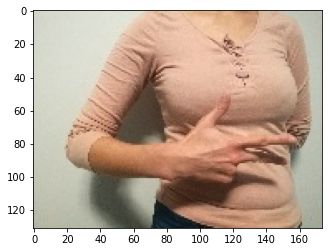

On image: 3


In [34]:
nmb = 2
my_hand = X_test[nmb]
show_img(nmb, X_test, Y_cat_test)

In [37]:
my_hand = my_hand.reshape(1, 131, 174, 3)
result = CNN.predict_classes(my_hand)
result = int(result)
print('CNN says: ' + class_names[result])

18
CNN says: N


## Predictions for individual classes

In [22]:
predictions = CNN.predict_classes(X_test)

In [23]:
print(classification_report(Y_test,predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        11
           2       0.17      0.18      0.17        11
           3       0.00      0.00      0.00        11
           4       0.04      1.00      0.08        11
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        11
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00        11
          15       0.00      0.00      0.00        11
          16       0.00      0.00      0.00        11
          17       0.00      0.00      0.00        11
          18       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
